# アンサンブル学習とランダムフォレスト

一群の予測機(分析器や回帰器)の予測を一つにまとめる、もっと優れている予測器の答えの方が良い予測を得られることが多い、この予測器のグループを`アンサンブル`と呼ぶ。この手法を`アンサンブル学習`、アンサンブル学習アルゴリズムを`アンサンブルメソッド`と呼ぶ

例として、訓練セットから無作為に作った様々サブセットを使って一連の決定木分類器を訓練し、予測するときには全ての決定木の予測を集め、多数決で予測クラスを決める。このような決定木のアンサンブルを`ランダムフォレスト`と呼ぶ。

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


投票分類器は個別の分類器のどれよりもわずかながら高い性能を示している。

全ての分類器がクラスに属する確率を推計できるメソッド(`predict_proba()`)がある場合、個別の分類器の確率を平均し、もっとも確率が高いクラスを返すことができるようにする。これを`ソフト投票`と呼ぶ。この方法だと、自身の高い投票の重みがますため、ハード投票よりも高い性能を示すことが多い。

In [18]:
# votingをsoftにする
# SVCのprobabilityハイパーパラメータをTrueにする
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [19]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


ハード投票よりも高い性能が出た

## バギングとペースティング
訓練セットから無作為に別々のサブセットをサンプリングして訓練するというアプローチもある。サンプリングが重複でありで行われるときは`バギング`、重複なしで行われるときは`ペースティング`と呼ぶ。

全ての分類器を予測したら、アンサンブルは単純に全ての予測器の予測を集計して新しいインスタンスに対する予測をする。  
集計関数は、一般的に分類では`モード`(ハード投票と同じく予測の最頻値をとる)、回帰は平均。

### scikit-learnにおけるバギングとペースティング

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [24]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-100
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [28]:
accuracy_score(y_test, y_pred)

0.92

BaggingClassifierは、ベースの分類器がクラスに属する確率を推計できるとき(predict_proba()メソッドがあるとき)には、デフォルトのハード投票ではなく、ソフト投票を実行する。

In [31]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [32]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Text(0.5, 1.0, 'Decision Trees with Bagging')

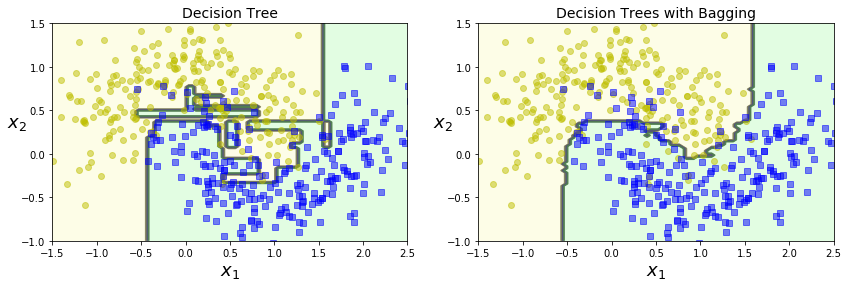

In [33]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

一つの決定木を使用したものと500個の機によるバギングアンサンブルを使用したときの決定境界を比較する。  
アンサンブルの予測の方が明らかに汎用性が高い。

### OOB検証
バギングでは、一部のインスタンスが同じ予測器に繰り返しサンプリングされるい一方で、全くサンプリングされないインスタンスもある。`BaggingClassifier`はデフォルトでm個の訓練インスタンスからサンプリングする。個々の予測器にサンプリングされるのは平均で訓練セットの63%だけになる。残りのサンプリングされない残り37%の訓練インスタンスは`OOB`(out-of-bag)インスタンスと呼ばれる。

予測器は訓練中にこのOOBインスタンスを見ていないので、べっっ子の検証セットを作成したり、交差検定をしなくとも、このOBBインスタンスを使用して検証することができる。

In [38]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

OOB検証によると90.1%の正解率がありそう

In [39]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [42]:
bag_clf.oob_decision_function_[:5]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## ランダムフォレスト
RandomForestClassifierクラスの方が便利だけでなく、決定木に適しているようになっている。